<h1>1. LIBRARIES

In [1]:
# import the necessary libraries 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

<h1>2. DATA

In [2]:
# holiday
holday_event_file_path = ("/home/munyao/Desktop/flat_iron_school/VIca Team/Data/holidays_events.csv")
holidays_event = pd.read_csv(holday_event_file_path)

# oil
oil_df = pd.read_csv("/home/munyao/Desktop/flat_iron_school/VIca Team/Data/oil.csv")
oil_df['date'] = pd.to_datetime(oil_df['date'])


# stores
store_data = pd.read_csv("/home/munyao/Desktop/flat_iron_school/VIca Team/Data/stores.csv")

# train data
train_data = pd.read_csv("/home/munyao/Desktop/flat_iron_school/VIca Team/Data/train.csv")
train_data['date'] = pd.to_datetime(train_data['date'])

# transaction data
transactions_df = pd.read_csv('/home/munyao/Desktop/flat_iron_school/VIca Team/Data/transactions.csv')

# test data
test_data = pd.read_csv('/home/munyao/Desktop/flat_iron_school/VIca Team/Data/test.csv')

<h2>2.1. Merge Datasets

<h3>2.1.1. Train and Store Data

In [3]:
# preprocess store before merging
store_data['store_type'] = store_data['type']
store_data = store_data.drop(['type'], axis=1)

# merger train data and oil data
train_store_df = pd.merge(train_data,store_data,how='left',on='store_nbr')

<h3>2.1.2. Train and Oil Data</h3>

>performing a left join operation between the "train_store_df" and "oil_df" DataFrames on the "date" column, to merge the oil prices data with the corresponding dates present in the training data

In [4]:
# get unique dates
print(len(train_store_df.date.unique()) , len(oil_df.date.unique()))

# preprocess the oil df before merging
dates_df = pd.DataFrame(train_store_df.date.unique(),columns=['date'])
dates_df['date'] = pd.to_datetime(dates_df['date'])
oil_data = pd.merge(dates_df, oil_df, how="left", on="date")
oil_data = oil_df.set_index('date')

# merge with train_store df
train_store_oil_df = pd.merge(train_store_df,oil_data,how='left',on='date')

# fil missing values in dcoilwtico column with the mean value
train_store_oil_df['dcoilwtico'].fillna(train_store_oil_df['dcoilwtico'].mean(), inplace=True)


1684 1218


<h3>2.1.3. Train and Holidays</h3>

>create a new DataFrame that summarizes the number of holidays of each type that occurred on each date, then left join on the date column will keep all the rows in the train_df DataFrame and add the holiday information as new columns.


In [5]:
# filter out transferred holidays
holidays_df = holidays_event[holidays_event['transferred'] == False]

# create a new DataFrame containing only date and type columns
holidays = holidays_df[['date', 'type']].copy()
holidays['date'] = pd.to_datetime(holidays['date'])

# pivot holidays DataFrame to create a new DataFrame with one row for each date
# and columns for each type of holiday
holiday_types = holidays.pivot_table(index='date', columns='type', aggfunc=len, fill_value=0)
holiday_types.columns = ['holiday_' + col.lower().replace(' ', '_') for col in holiday_types.columns]
holiday_types.reset_index(inplace=True)

# merge holiday_types DataFrame with train_df using left join on date column
train_df = pd.merge(train_store_oil_df, holiday_types, how='left', on='date')


In [6]:
# transactions
transactions_df['date'] = pd.to_datetime(transactions_df['date'])
train_df = pd.merge(train_df, transactions_df, how='left', on=['date', 'store_nbr'])

# set 'date' column as index
train_df.set_index('date', inplace=True)

# preview the data
train_df.head(7)

,id,store_nbr,family,sales,onpromotion,city,state,cluster,store_type,dcoilwtico,holiday_additional,holiday_bridge,holiday_event,holiday_holiday,holiday_transfer,holiday_work_day,transactions
date,,,,,,,,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,13,D,67.925589,0.0,0.0,0.0,1.0,0.0,0.0,NaN
2013-01-01,1,1,BABY CARE,0.0,0,Quito,Pichincha,13,D,67.925589,0.0,0.0,0.0,1.0,0.0,0.0,NaN
2013-01-01,2,1,BEAUTY,0.0,0,Quito,Pichincha,13,D,67.925589,0.0,0.0,0.0,1.0,0.0,0.0,NaN
2013-01-01,3,1,BEVERAGES,0.0,0,Quito,Pichincha,13,D,67.925589,0.0,0.0,0.0,1.0,0.0,0.0,NaN
2013-01-01,4,1,BOOKS,0.0,0,Quito,Pichincha,13,D,67.925589,0.0,0.0,0.0,1.0,0.0,0.0,NaN
2013-01-01,5,1,BREAD/BAKERY,0.0,0,Quito,Pichincha,13,D,67.925589,0.0,0.0,0.0,1.0,0.0,0.0,NaN
2013-01-01,6,1,CELEBRATION,0.0,0,Quito,Pichincha,13,D,67.925589,0.0,0.0,0.0,1.0,0.0,0.0,NaN


In [10]:
train_df.transactions

date
2013-01-01    1694.602158
2013-01-01    1694.602158
2013-01-01    1694.602158
2013-01-01    1694.602158
2013-01-01    1694.602158
                 ...     
2017-08-15    2155.000000
2017-08-15    2155.000000
2017-08-15    2155.000000
2017-08-15    2155.000000
2017-08-15    2155.000000
Name: transactions, Length: 3000888, dtype: float64

In [9]:
train_df['transactions'].fillna(train_df['transactions'].mean(), inplace=True)


<h1>3. Exploratory Data Analysis

In [11]:
# shape 
train_df.shape

(3000888, 17)

<h2>3.1. Summary Statistics 

In [12]:
# Summary statistics of sales
train_df['sales'].describe().T


count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

>The statistics suggest that the "sales" variable is highly right-skewed, with a large number of values near 0 and a few very high values. This can also be seen by looking at the minimum value of 0 and the maximum value of 124,717, which is much larger than the 75th percentile value of 195.85.

<h2> 3.2. Distribution of Target Column

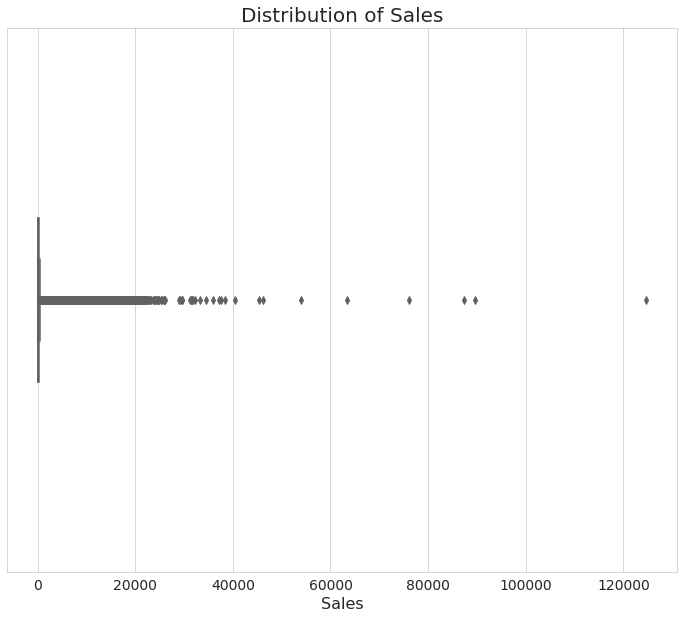

In [13]:
# box plot of the target column
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")
sns.boxplot(x=train_df['sales'], palette="Blues_r", width=0.3)
plt.title("Distribution of Sales", fontsize=20)
plt.xlabel("Sales", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

<h2>3.3. Time Series Visualization

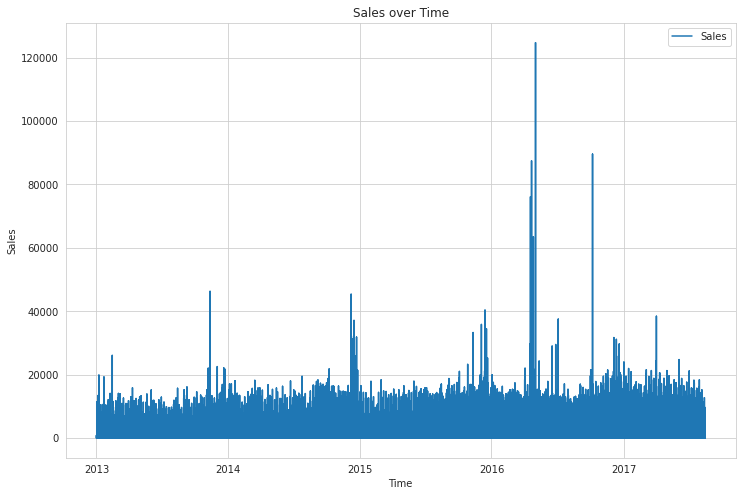

In [14]:
# time series plot of sales over time
plt.figure(figsize=(12, 8))
plt.plot(train_df.index, train_df['sales'], label='Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Sales over Time')
plt.legend()
plt.show()


<h2>3.4. Monthly Sales Trend

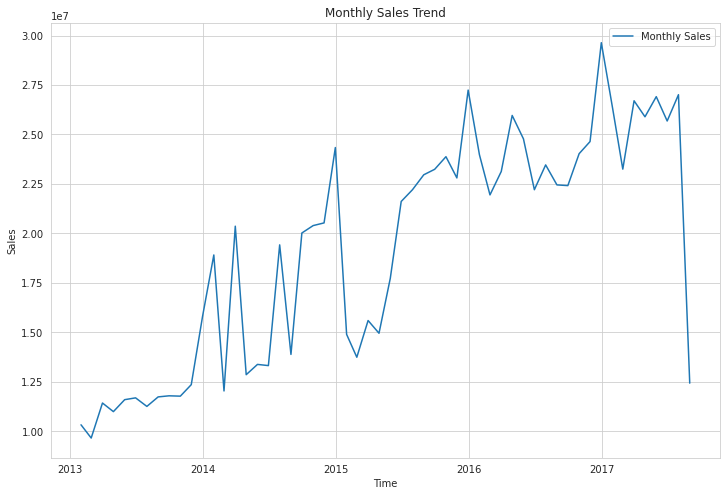

In [15]:
# get the monthly sales
monthly_sales = train_df['sales'].resample('M').sum()

plt.figure(figsize=(12, 8))
plt.plot(monthly_sales.index, monthly_sales, label='Monthly Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Monthly Sales Trend')
plt.legend()
plt.show()


<h2>3.5. Seasonal decomposition of sales

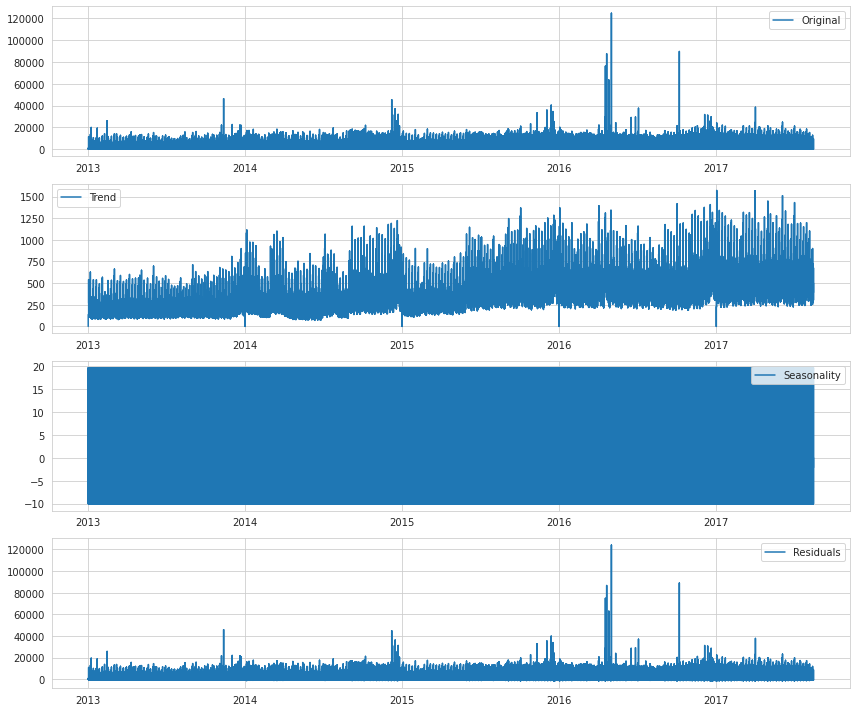

In [16]:
result = seasonal_decompose(train_df['sales'], model='additive', period=365)

plt.figure(figsize=(12, 10))

plt.subplot(411)
plt.plot(train_df['sales'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(result.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(result.resid, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


<h2>3.6. Autocorrelation plot of Sales

In [ ]:
# # autocorrelation plot
# plt.figure(figsize=(12, 8))
# plot_acf(train_df['sales'], lags=30)
# plt.xlabel('Lags')
# plt.ylabel('Autocorrelation')
# plt.title('Autocorrelation Plot')
# plt.show()


<h2>3.7. Partial Autocorrelation plot of Sales

/home/munyao/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 864x720 with 0 Axes>

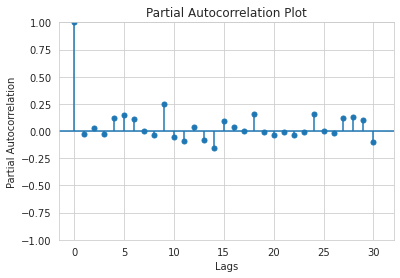

In [17]:
# partial autocorrelation plot
plt.figure(figsize=(12, 10))
plot_pacf(train_df['sales'], lags=30)
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Plot')
plt.show()


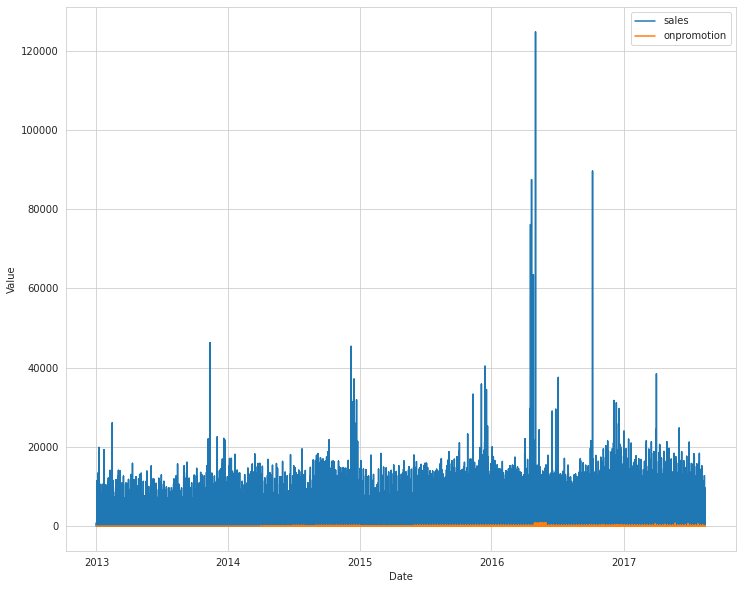

In [24]:
plt.figure(figsize=(12,10))
plt.plot(train_df.index, train_df['sales'])
plt.plot(train_df.index, train_df['onpromotion'])
plt.legend(['sales', 'onpromotion'])
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

<h1>4. Feature Engineering


<h2>4.1. Target Column

apply a logarithmic transformation to the sales values to reduce the influence of extreme outliers and improve the normality of the distribution

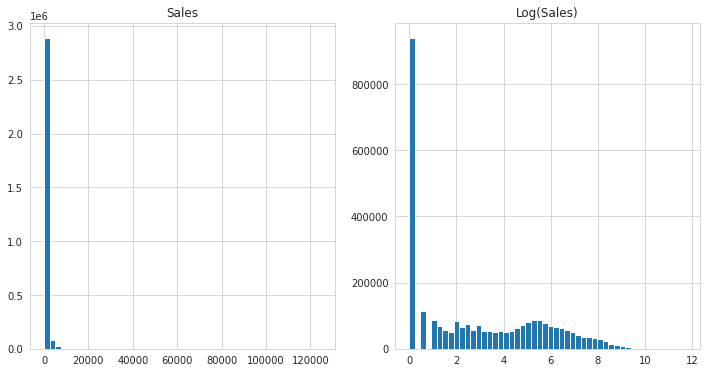

In [25]:
# apply logarithmic transformation
train_df['log_sales'] = np.log1p(train_df['sales'])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Plot histogram for sales
ax1.hist(train_df['sales'], bins=50)
ax1.set_title('Sales')

# Plot histogram for log(sales)
ax2.hist(train_df['log_sales'], bins=50)
ax2.set_title('Log(Sales)')

plt.show()

<h1>5.1. Model

In [26]:
train_df.head(7)

,id,store_nbr,family,sales,onpromotion,city,state,cluster,store_type,dcoilwtico,holiday_additional,holiday_bridge,holiday_event,holiday_holiday,holiday_transfer,holiday_work_day,transactions,log_sales
date,,,,,,,,,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,13,D,67.925589,0.0,0.0,0.0,1.0,0.0,0.0,1694.602158,0.0
2013-01-01,1,1,BABY CARE,0.0,0,Quito,Pichincha,13,D,67.925589,0.0,0.0,0.0,1.0,0.0,0.0,1694.602158,0.0
2013-01-01,2,1,BEAUTY,0.0,0,Quito,Pichincha,13,D,67.925589,0.0,0.0,0.0,1.0,0.0,0.0,1694.602158,0.0
2013-01-01,3,1,BEVERAGES,0.0,0,Quito,Pichincha,13,D,67.925589,0.0,0.0,0.0,1.0,0.0,0.0,1694.602158,0.0
2013-01-01,4,1,BOOKS,0.0,0,Quito,Pichincha,13,D,67.925589,0.0,0.0,0.0,1.0,0.0,0.0,1694.602158,0.0
2013-01-01,5,1,BREAD/BAKERY,0.0,0,Quito,Pichincha,13,D,67.925589,0.0,0.0,0.0,1.0,0.0,0.0,1694.602158,0.0
2013-01-01,6,1,CELEBRATION,0.0,0,Quito,Pichincha,13,D,67.925589,0.0,0.0,0.0,1.0,0.0,0.0,1694.602158,0.0


In [27]:
# Create dummy variables for categorical columns
train_df = pd.get_dummies(train_df, columns=['family', 'onpromotion', 'city', 'state', 'store_type', 'cluster'])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_df.drop(['sales', 'log_sales'], axis=1), train_df['log_sales'], test_size=0.2, random_state=42)


: 

: 

In [ ]:
# Train a random forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)



In [ ]:
# Evaluate the model on the validation set
y_pred = rf_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print('Random Forest RMSE:', rmse)
